## DV1597 Assignment 2
Group 9


***
Viktor Fransson

vifr22@student.bth.se

***

Tobias Gustafsson

togu22@student.bth.se
***

#### Initialize

In [77]:
# Import packages
import pandas as pd
import matplotlib.pyplot as mpl # Version 3.8.4
import seaborn as sb
import numpy as np
import scipy.stats as stats
import geopandas as gpd
from IPython.display import display, HTML, display_html
from shapely.geometry import Polygon
import fsspec

In [78]:
# Ignore future and deprecation warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [79]:
# Load datasets
PATH = 'Assignment 2_datasets/'
df_daily_original = pd.read_csv(PATH + '1.COVID-19_daily_number_of_new_cases_and_deaths.csv')
df_vaccination_original = pd.read_csv(PATH + '2.COVID-19_vaccination.csv')
df_admissions_original = pd.read_csv(PATH + '3.COVID-19_hospital_and_ICU_admission_rates.csv')

***


#### Data munging

Store country data in a dictionary. For fetching country name and population from geoID.

In [80]:
# Load countries, drop unwanted (for this) columns.
df_pop = df_daily_original.copy().groupby('countriesAndTerritories').first().reset_index()
df_pop.drop(['dateRep', 'day','month', 'year', 'cases','deaths','countryterritoryCode', 'continentExp'], axis=1, inplace=True)

pop_dict = {}
name_dict = {}

# Extract population and name data and store in dictionary
for i in range(len(df_pop)):
    geo_id = df_pop.iloc[i]['geoId']
    country = df_pop.iloc[i]['countriesAndTerritories']
    pop_data = df_pop.iloc[i]['popData2020']
    pop_dict[geo_id] = pop_data
    pop_dict[country] = pop_data
    name_dict[geo_id] = country

Create copies of the datasets, to be modified

In [81]:
# Create copies of the original datasets
df_daily = df_daily_original.copy()
df_admissions = df_admissions_original.copy()
df_vaccination = df_vaccination_original.copy()

##### Munging 1. Daily cases and deaths

In [82]:
# Add dateTime column
df_daily['Time'] = pd.to_datetime(df_daily['dateRep'], format='%d/%m/%Y')
df_daily.set_index('Time', inplace=True)

##### Munging of 2. Vaccine data

Replace NaN-values in numerical columns with 0. 

Some countries have reported data for each region, we remove the region data since we are not interested in regional differences.



In [83]:
# Columns where NaN is to be replaced with 0
num_cols = ['NumberDosesReceived','NumberDosesExported','FirstDose','FirstDoseRefused','SecondDose','DoseAdditional1','DoseAdditional2','DoseAdditional3','DoseAdditional4','DoseAdditional5','UnknownDose']

# Drop regional data
df_vaccination = df_vaccination.drop(df_vaccination[df_vaccination['Region'] != df_vaccination['ReportingCountry']].index)

# Replace NaN with zero for selected columns
for column in num_cols:
    df_vaccination[column] = df_vaccination[column].fillna(0)

Countries have reported the data in slightly different ways. We add two age groups for the countries that does not already have them: Age<18 and 1_Age60+.

In [84]:
# Under 18 and 60+ target groups
u18_list = ['Age0_4', 'Age5_9', 'Age10_14', 'Age15_17']
o60_list = ['Age60_69', 'Age70_79', 'Age80+']
groups = (('Age<18',u18_list), ('1_Age60+',o60_list))

# Create a group of all countries
df_country = df_vaccination.groupby('ReportingCountry')

# Create a list for adding new rows
all_rows = [df_vaccination]

# Iterate over each country
for country in df_country:
    # Get data for the country, find all the targetgroups
    dfc = df_vaccination.loc[df_vaccination['ReportingCountry'] == country[0]]
    df_temp = dfc.groupby('TargetGroup').first().reset_index()
    
    for g in groups:
        if g[0] not in df_temp['TargetGroup'].values:
            # Remove all TargetGroups of wrong type, sum the rest
            dfc_age = dfc[dfc['TargetGroup'].isin(g[1])].reset_index(drop=True)
            dfc_age_group = dfc_age.groupby(['YearWeekISO','ReportingCountry','NumberDosesReceived','NumberDosesExported','Region','Vaccine','Population']).sum().reset_index()

            # Calculate denominator for Age-group
            denominator = dfc_age_group.groupby('TargetGroup').first().sum().loc['Denominator']
            dfc_age_group = dfc_age_group.assign(Denominator=denominator)
            
            # Rename TargetGroup, add to list
            dfc_age_group = dfc_age_group.assign(TargetGroup=g[0])
            all_rows.append(dfc_age_group)
    
# Add values to df_vaccination
df_vaccination = pd.concat(all_rows, ignore_index=True)


Change some columns from type float to int

In [85]:
# Columns to change from type float to int
float_columns = ['FirstDoseRefused','NumberDosesReceived','NumberDosesExported']
for f in float_columns:
    df_vaccination[f] = df_vaccination[f].astype(int)

##### Munging of 3. hospital and ICU data

In [86]:
# Add dateTime column
df_admissions['Time'] = pd.to_datetime(df_admissions['date'])

In [87]:
df_ind = df_admissions.iloc[:, [0, 1]]
df_ind
country_dict = {}
country = "Country_name"
measure = ["way to measure"]

for i in range(len(df_ind) -1):
    if country != df_ind.iat[i, 0]:
        country_dict[country] = measure
        country = df_ind.iat[i, 0]
        measure = []
    
    if df_ind.iat[i, 1] not in measure:
        measure.append(df_ind.iat[i, 1])

for country in country_dict:
    print(country, country_dict[country])

Country_name ['way to measure']
Austria ['Daily hospital occupancy', 'Daily ICU occupancy']
Belgium ['Daily hospital occupancy', 'Daily ICU occupancy', 'Weekly new hospital admissions per 100k']
Bulgaria ['Daily hospital occupancy', 'Daily ICU occupancy']
Cyprus ['Daily hospital occupancy', 'Daily ICU occupancy', 'Weekly new hospital admissions per 100k', 'Weekly new ICU admissions per 100k']
Czechia ['Daily hospital occupancy', 'Daily ICU occupancy', 'Weekly new hospital admissions per 100k', 'Weekly new ICU admissions per 100k']
Estonia ['Daily hospital occupancy', 'Daily ICU occupancy', 'Weekly new hospital admissions per 100k', 'Weekly new ICU admissions per 100k']
France ['Daily hospital occupancy', 'Daily ICU occupancy', 'Weekly new hospital admissions per 100k', 'Weekly new ICU admissions per 100k']
Germany ['Daily ICU occupancy', 'Weekly new hospital admissions per 100k']
Greece ['Weekly new hospital admissions per 100k', 'Weekly new ICU admissions per 100k']
Hungary ['Weekly n

### Part 1

***
#### 1.
Since 2020 till 2022, which top 10 countries reported the most number of cases of COVID-19 in quarters per year (Q1-Q4 in each year)? Do you find these numbers relatively high compared to the country’s population? Do you see any connection among these countries regarding their geographical locations and the period in which most cases are observed? Discuss your observations.

In [88]:
# Divide into quarters
quarters = df_daily.resample('QE')

styled_dfs = [] # Store tables
quarterly_dfs = {}

# Calculate totalt deaths per quarter for each country
for name, quarter_df in quarters:
    # Sum up deaths for each country every quarter of a year, sort based on most deaths
    group = quarter_df.groupby('countriesAndTerritories')['cases'].sum().reset_index()
    group = group.sort_values('cases', ascending=False).reset_index(drop=True)
    
    # Rename columns, index starts at 1 
    group.rename(columns = {'countriesAndTerritories':'Country', 'cases':'Cases'}, inplace = True)
    group.index += 1
    
    # Retrieve population data, calculate deaths per million inhabitants
    group['Population'] = group['Country'].map(pop_dict)
    group['Cpm'] = (group['Cases']/(group['Population']/1000000)).round(2)
    group.drop(['Population'], axis=1, inplace=True)
    
    # Add top10 to output list
    styled_dfs.append(group.head(10).style.format(precision=0).format_index(str.upper, axis=1))

# Format output, 4 tables in width
html_output = "<div style='display: flex; flex-wrap: wrap;'>"
for i, styled_df in enumerate(styled_dfs):
    if i%4 == 0: # Year header
        html_output += "<h2>202"+str(i//4)+"</h2></div><div style='display: flex; flex-wrap: wrap;'>"
    html_output += "<div style='width: 30%; padding: 40px;'> Q"+str((i)%4+1)+styled_df.to_html()+"</div>" # Table
    if (i+1) % 2 == 0: # New row
        html_output += "</div><div style='display: flex; flex-wrap: wrap;'>" 
html_output += "</div>"
display_html(html_output,raw=True)

# Times = ['2020 Q1', '2020 Q2', '2020 Q3', '2020 Q4', '2021 Q1', '2021 Q2', '2021 Q3', '2021 Q4', '2022 Q1', '2022 Q2', '2022 Q3', '2022 Q4']
# # Save as LaTeX tables
# for i, df in enumerate(styled_dfs):
#     latex_table = df.to_latex(caption=Times[i])
#     latex_table = latex_table.replace('\\begin{table}', '\\begin{table}[H] \scriptsize')
#     print(latex_table)


,COUNTRY,CASES,CPM
1,Spain,167645,3542
2,Italy,105792,1774
3,Germany,74061,891
4,France,52128,774
5,Belgium,16977,1473
6,Netherlands,12449,715
7,Austria,7312,821
8,Portugal,7251,704
9,Norway,5107,951
10,Sweden,4834,468


***
#### 2.
Visualize each country’s total number of cases and deaths on a map plot using their geographical locations in 2020, 2021, and 2022. Discuss your observations.

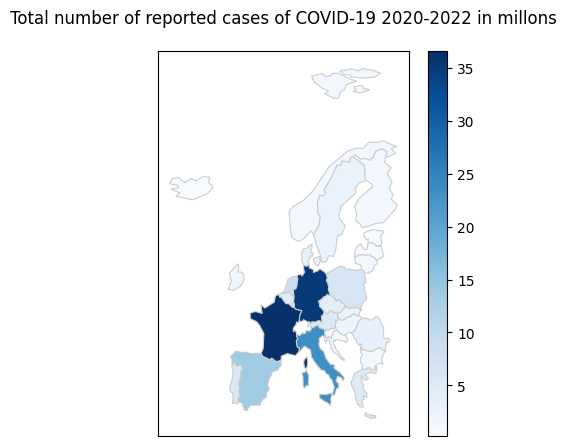

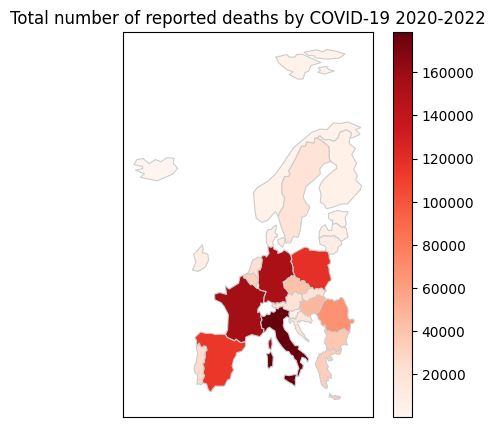

In [89]:
# Create dataframes that sums all deaths and cases
df_deaths = df_daily.groupby('countriesAndTerritories')['deaths'].sum().reset_index()

df_cases = df_daily.groupby('countriesAndTerritories')['cases'].sum().reset_index()
df_cases['Million Cases'] = df_cases['cases']/1000000

# Load European map data from geopandas datasets
europe = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = europe[europe['continent'] == 'Europe']

# Code to remove a french territory far away from europe
coordinates = ""
start = False
for char in str(europe.iat[2,5]):
    if char == ")":
        break
    if char == "-":
        start = True
    if start:
        coordinates += char

coordinates = [tuple(map(float, coord.split(' '))) for coord in coordinates.split(', ')]
coordinates = Polygon(coordinates)
europe.iat[2, 5] = europe.iat[2, 5].difference(coordinates)

# Merge dataframes with the European map based on the 'country' column
cases_map = europe.merge(df_cases, left_on='name', right_on='countriesAndTerritories')
deaths_map = europe.merge(df_deaths, left_on='name', right_on='countriesAndTerritories')

# Plotting the merged data, coloring countries based on cases or deaths
fig_c = mpl.figure(figsize=(5, 5))
ax_c = fig_c.add_subplot()
ax_c.set_xticks([])
ax_c.set_yticks([])
mpl.title('Total number of reported cases of COVID-19 2020-2022 in millons', pad=20)
cases_map.plot(column='Million Cases', cmap='Blues', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax_c)

fig_d = mpl.figure(figsize=(5, 5))
ax_d = fig_d.add_subplot()
ax_d.set_xticks([])
ax_d.set_yticks([])
mpl.title('Total number of reported deaths by COVID-19 2020-2022')
deaths_map.plot(column='deaths', cmap='Reds', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax_d)
mpl.show()

***
#### 3.
What are the top 3 popular vaccine brands that have been used across the EU/EEA? Can you observe the same popularity at the country level? Are there any exceptions?

In [90]:
# Create dataframe with summed up NumberDosesReceived for each vaccine
df_vaccines = df_vaccination.groupby('Vaccine')['NumberDosesReceived'].sum().reset_index()
df_sorted = df_vaccines.sort_values(by='NumberDosesReceived', ascending=False)

# Top 3 (without "unknown")
df_sorted = df_sorted.drop(16).head(3).reset_index(drop=True)
df_sorted.reset_index().drop(columns='index', axis=1)

# Top 3 for each country
grouped = df_vaccination.groupby(['ReportingCountry', 'Vaccine'])['NumberDosesReceived'].sum().reset_index()

# Apply lambda-function to each group and concatenate the results
grouped = grouped.groupby('ReportingCountry')
grouped = grouped.apply(lambda x: x.nlargest(3, 'NumberDosesReceived')).reset_index(drop=True)
grouped = grouped[['ReportingCountry', 'Vaccine']]
grouped_top_3 = grouped.groupby('ReportingCountry')['Vaccine'].agg(list)

# Convert the list of vaccines into separate columns (Top 1, Top 2, Top 3)
grouped_top_3 = pd.DataFrame(grouped_top_3.tolist(), index=grouped_top_3.index, columns=['Top 1', 'Top 2', 'Top 3'])

# Reset index, Replace country code with country name, sort by name
grouped_top_3.reset_index(inplace=True)
grouped_top_3['ReportingCountry'] = grouped_top_3['ReportingCountry'].map(name_dict)
grouped_top_3 = grouped_top_3.sort_values(by='ReportingCountry', ascending=True)

# Replace UNK and None with -. for Germany
grouped_top_3.loc[grouped_top_3['ReportingCountry'] == 'Germany', ['Top 1', 'Top 2', 'Top 3']] = '-'


# Start counting from 1
df_sorted.index += 1

display(df_sorted)
display(grouped_top_3.style.hide())

# Save as LaTeX tables
# latex_table = df_sorted.to_latex(caption='Top 3 vaccine brands used in EU/EEA')
# latex_table = latex_table.replace('\\begin{table}', '\\begin{table}[H] \scriptsize')
# print(latex_table)
# latex_table = grouped_top_3.style.hide().to_latex(caption='Top 3 vaccine brands used for each country')
# latex_table = latex_table.replace('\\begin{table}', '\\begin{table}[H] \scriptsize')
# print(latex_table)

,Vaccine,NumberDosesReceived
1,COM,695126737
2,MOD,197601312
3,AZ,131393402


ReportingCountry,Top 1,Top 2,Top 3
Austria,COM,MOD,AZ
Belgium,COM,MOD,AZ
Bulgaria,COM,AZ,JANSS
Croatia,COM,AZ,MOD
Cyprus,COM,AZ,JANSS
Czechia,COM,COMBA.4-5,MOD
Denmark,COM,MOD,AZ
Estonia,COM,AZ,COMBA.4-5
Finland,COM,COMBA.4-5,MOD
France,COM,MOD,COMBA.4-5


***
#### 4.
Considering the previous question, which target groups mainly received these vaccine brands in each country?

In [91]:
# Copy of dataframe
df_vaccines = df_vaccination.copy()

# Add together the different doses because 'NumberOfDoses' didn't work correctly with each target group
df_vaccines['Additional'] = df_vaccines['DoseAdditional1'] + df_vaccines['DoseAdditional2'] + df_vaccines['DoseAdditional3'] + df_vaccines['DoseAdditional4'] + df_vaccines['DoseAdditional5']
df_vaccines['Doses'] = df_vaccines['FirstDose'] + df_vaccines['SecondDose'] + df_vaccines['Additional']

# Remove unwanted targetgroups and sum up doses
df_vaccines = df_vaccines[~df_vaccines['TargetGroup'].isin(['ALL','1_Age60+','1_Age<60'])]
df_vaccines = df_vaccines.groupby(['ReportingCountry', 'Vaccine', 'TargetGroup'])['Doses'].sum().reset_index()

# Filter out top 3 vaccines we got from the last question
top_3 = ['COM', 'MOD', 'AZ']
df_filtered = df_vaccines[df_vaccines['Vaccine'].isin(top_3)]
grouped = df_filtered.groupby(['ReportingCountry', 'Vaccine'])

# Define a function to get the largest target group for each vaccine in each country
def get_largest_target_group(group):
    # Get the row with the maximum 'NumberDosesReceived'
    largest_row = group.loc[group['Doses'].idxmax()]
    return largest_row

# Apply the function to each group and create a new DataFrame
largest_target_group_df = grouped.apply(get_largest_target_group)

# Reset the index to include 'ReportingCountry' and 'Vaccine' as columns
largest_target_group_df = largest_target_group_df.reset_index(drop=True)
largest_target_group_df = largest_target_group_df[largest_target_group_df['Doses'] != 0]
largest_target_group_df['Country'] = largest_target_group_df['ReportingCountry'].map(name_dict)

# Create table with vaccine as columns
df = largest_target_group_df.pivot_table(index='Country', columns='Vaccine', values='TargetGroup', aggfunc='sum').reset_index()
# display(df)

data = {'Country':[], 'COM':[], 'MOD':[], 'AZ':[]}

# Rearrange the data, create new Dataframe, add missing countries (Germany and France)
for c in name_dict.values():
    data['Country'].append(c)
    slice = df[df['Country'] == c]
    if len(slice) == 0: # Countries with no data
        data['AZ'].append('-')
        data['COM'].append('-')
        data['MOD'].append('-')
    else:
        # Add TargetGroup data
        if c == 'Liechtenstein':
            data['AZ'].append('-') # Deals with NaN-value
        else:
            data['AZ'].append(slice.values[0][1])
        data['COM'].append(slice.values[0][2])
        data['MOD'].append(slice.values[0][3])

# FRANCE and GERMANY all vaccines are UNK
df = pd.DataFrame(data)
display(df.style.hide())

# Save as LaTeX tables
# latex_table = df.style.hide().to_latex(caption='Top 3 vaccine brands target groups')
# latex_table = latex_table.replace('\\begin{table}', '\\begin{table}[H] \scriptsize')
# latex_table = latex_table.replace('_', '\\_')
# print(latex_table)


Country,COM,MOD,AZ
Austria,Age25_49,Age25_49,Age25_49
Belgium,Age25_49,Age25_49,Age50_59
Bulgaria,Age25_49,Age25_49,Age25_49
Croatia,Age25_49,Age25_49,Age70_79
Cyprus,Age25_49,Age25_49,Age25_49
Czechia,Age25_49,Age25_49,Age70_79
Denmark,Age25_49,Age25_49,HCW
Estonia,Age25_49,Age25_49,Age60_69
Finland,Age25_49,Age25_49,Age60_69
France,-,-,-


***
#### 5.
Which countries are the most skeptical towards the first dose of the COVID-19 vaccine? Do you think this matter had any impact on the hospitalization level?

In [92]:
# Retrieve firstDose data for 18+ population
df_firstdose = df_vaccination[df_vaccination['TargetGroup']=='ALL']

# Create dataframe with summed up NumberDosesReceived for each vaccine
df_firstdose = df_firstdose.groupby('ReportingCountry')['FirstDose'].sum().reset_index()

df_firstdose['Population'] = df_firstdose['ReportingCountry'].map(pop_dict)

# Calculate skepticism as 1 - (FirstDose / Population)
df_firstdose['Skepticism'] = (1 - (df_firstdose['FirstDose'] / df_firstdose['Population'])).round(2)

# Create a new DataFrame with 'Country' and 'Skepticism' columns
df_skepticism = df_firstdose[['ReportingCountry', 'FirstDose', 'Population', 'Skepticism']]

# Rename the 'ReportingCountry' column to 'Country' for consistency
df_skepticism = df_skepticism.rename(columns={'ReportingCountry': 'Country'})
df_skepticism = df_skepticism.sort_values(by='Skepticism', ascending=False).reset_index(drop=True)
df_skepticism['Country'] = df_skepticism['Country'].map(name_dict)
df_skepticism.index += 1
df_skepticism['Skepticism'] = df_skepticism['Skepticism'].astype(str)

display(df_skepticism.style.hide())

# Save as LaTeX tables
# latex_table = df_skepticism.to_latex(caption='Skepticism toward COVID-19-vaccine')
# latex_table = latex_table.replace('\\begin{table}', '\\begin{table}[H] \scriptsize')
# print(latex_table)

Country,FirstDose,Population,Skepticism
Bulgaria,2077742,6951482,0.7
Romania,7917501,19328838,0.59
Slovakia,2704559,5457873,0.5
Poland,20848103,37958138,0.45
Croatia,2282163,4058165,0.44
Slovenia,1180783,2095861,0.44
Estonia,796997,1328976,0.4
Czechia,6551506,10693939,0.39
Hungary,5921482,9769526,0.39
Liechtenstein,25061,38747,0.35


***
#### 6.
Rank all EU/EEA countries, based on their vaccinated population under age 18 for the first dose of the COVID-19 vaccine, which countries have the most and least vaccinated people under age 18 in regards to their total populations?

In [93]:
# Groupby first dose
df6g = df_vaccination.groupby(['ReportingCountry','TargetGroup'])['FirstDose'].sum().reset_index()
df6g = df6g.loc[df6g['TargetGroup'] == 'Age<18']

# Add Population data and country name
df6g['Population'] =df6g['ReportingCountry'].map(pop_dict)
df6g['Country'] =df6g['ReportingCountry'].map(name_dict)

# Calculate percentage of total population
df6g['Proportion'] = (df6g['FirstDose']/df6g['Population']).round(3)

# Order columns
cols = ['Country','Population','FirstDose', 'Proportion']
df6g=df6g.reindex(columns=cols)

# Sort by perc
df6g = df6g.sort_values('Proportion', ascending=False).reset_index(drop=True)
df6g.index += 1
print('Highest amount first doses for under 18 populations with regards to total population')
display(df6g.head(5))
df6g = df6g.sort_values('Proportion', ascending=True).reset_index(drop=True)
df6g.index += 1
print('Least amount of first doses under 18 populations with regards to total population')
display(df6g.head(5))

# Sort
df6g = df6g.sort_values('FirstDose', ascending=False).reset_index(drop=True)
df6g.index += 1
print('Total first doses for under 18 populations')
display(df6g)

# Save as LaTeX tables
# df6g['Perc'] = df6g['Proportion'].astype(str)
# latex_table = df6g.to_latex(caption='People under 18 who recieved the first dose of COVID-19 vaccination for each country')
# latex_table = latex_table.replace('\\begin{table}', '\\begin{table}[H] \scriptsize')
# print(latex_table)

Highest amount first doses for under 18 populations with regards to total population


,Country,Population,FirstDose,Proportion
1,Iceland,364134,43091,0.118
2,Spain,47332614,4859297,0.103
3,Portugal,10295909,1003285,0.097
4,Finland,5525292,453284,0.082
5,Ireland,4964440,400424,0.081


Least amount of first doses under 18 populations with regards to total population


,Country,Population,FirstDose,Proportion
1,Bulgaria,6951482,28612,0.004
2,Croatia,4058165,35087,0.009
3,Romania,19328838,270224,0.014
4,Slovenia,2095861,43805,0.021
5,Slovakia,5457873,134575,0.025


Total first doses for under 18 populations


,Country,Population,FirstDose,Proportion
1,Spain,47332614,4859297,0.103
2,France,67320216,4608158,0.068
3,Germany,83166711,4563350,0.055
4,Italy,59641488,4332328,0.073
5,Poland,37958138,1784079,0.047
6,Portugal,10295909,1003285,0.097
7,Netherlands,17407585,895339,0.051
8,Belgium,11522440,861956,0.075
9,Austria,8901064,525642,0.059
10,Greece,10718565,483328,0.045


***
#### 7.
Which countries have the oldest vaccinated population for the **second** dose of the COVID-19 vaccine in regards to their total population?

In [94]:
# Copy dataset, keep rows where age is 60+, groupby country and sum second dose
df7 = df_vaccination.copy()
df7 = df7.loc[df7['TargetGroup'] == '1_Age60+']
df7g = df7.groupby(['ReportingCountry'])['SecondDose'].sum().reset_index()

# Add Population data and country name
df7g['Country'] =df7g['ReportingCountry'].map(name_dict)
df7g['Population'] =df7g['ReportingCountry'].map(pop_dict)

# Calculate percentage of total population
df7g['Proportion'] = (df7g['SecondDose']/df7g['Population']).round(3)

# Sort
df7g = df7g.sort_values('Proportion',ascending=False).reset_index(drop=True)

# Display
df7g.index += 1
cols = ['Country','Population','SecondDose', 'Proportion']
df7g=df7g.reindex(columns=cols)
display(df7g)

# Save as LaTeX tables
# df7g['Perc'] = df7g['Proportion'].astype(str)
# latex_table = df7g.to_latex(caption='60+ population vaccinated with a second dose of COVID-19 vaccine')
# latex_table = latex_table.replace('\\begin{table}', '\\begin{table}[H] \scriptsize')
# print(latex_table)

,Country,Population,SecondDose,Proportion
1,Finland,5525292,1539025,0.279
2,Portugal,10295909,2850385,0.277
3,Italy,59641488,16207428,0.272
4,Germany,83166711,22007037,0.265
5,Denmark,5822763,1523615,0.262
6,Greece,10718565,2696484,0.252
7,France,67320216,16532224,0.246
8,Belgium,11522440,2840014,0.246
9,Spain,47332614,11572556,0.244
10,Malta,514564,124544,0.242


***
#### 8.
Which countries’ health care was most affected by the coronavirus pandemic in 2020 compared to others? How are these statistics in 2022?

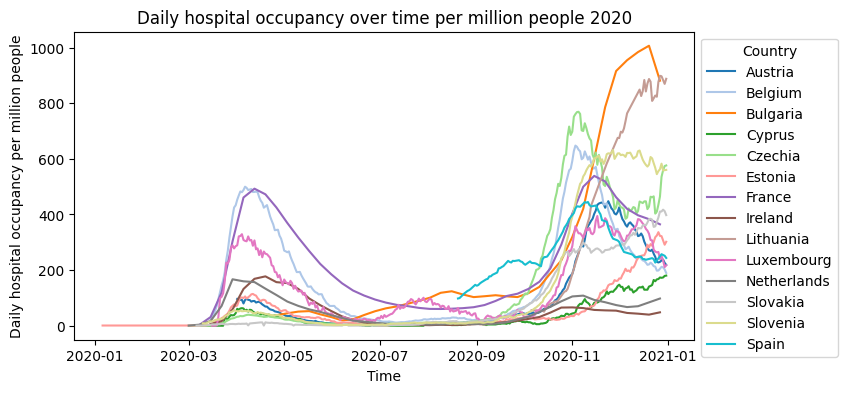

,country,median,std
1,Lithuania,695.9,349.3
2,Spain,243.7,92.0
3,France,158.1,167.6
4,Belgium,113.3,187.3
5,Bulgaria,105.8,323.9
6,Luxembourg,86.2,123.4
7,Netherlands,43.5,48.2
8,Ireland,36.7,50.2
9,Austria,33.4,134.4
10,Slovenia,27.7,227.1


In [95]:
# Copy admission dateset where Daily hospital occupancy is the indicator
df_admissions_daily = df_admissions[df_admissions['indicator']=='Daily hospital occupancy'].copy()
df_2020 = df_admissions_daily[df_admissions_daily['Time'].dt.year == 2020].copy()

# Create figure and colors
fig = mpl.figure(figsize=(8, 4))
ax = fig.add_subplot()
colors = mpl.cm.tab20(np.linspace(0, 1, 15))

# Add population data, calculate daily admissions per million people
df_2020['Population'] = df_2020['country'].map(pop_dict)
df_2020['value_pm'] = df_2020['value']/(df_2020['Population']/1000000)

# Create a line for each country
for i, country in enumerate(df_2020['country'].unique()):
    country_data_2020 = df_2020[df_2020['country'] == country]
    mpl.plot(country_data_2020['Time'], country_data_2020['value_pm'], label=country, color=colors[i])

# Add info to plot
mpl.xlabel('Time')
mpl.ylabel('Daily hospital occupancy per million people')
mpl.legend(title='Country', bbox_to_anchor=(1, 1))
mpl.title('Daily hospital occupancy over time per million people 2020')
mpl.show()

# Calculate median and std, create table
# 2020
df_co_2020 = df_2020.groupby('country')['value_pm'].agg(['median','std']).reset_index()
df_co_2020 = df_co_2020.round({'median': 1, 'std': 1})
df_co_2020 = df_co_2020.sort_values(by='median', ascending=False).reset_index(drop=True)
df_co_2020.index += 1

display(df_co_2020)

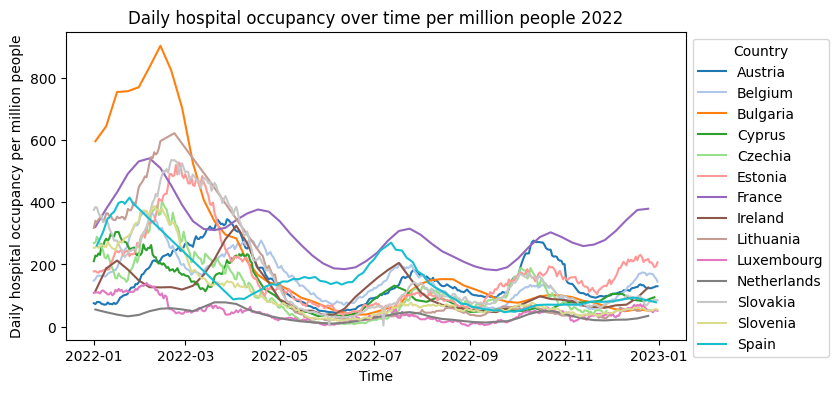

,country,median,std
1,France,296.7,91.7
2,Cyprus,181.9,75.3
3,Estonia,145.2,117.3
4,Spain,143.1,116.0
5,Belgium,138.6,77.5
6,Austria,126.4,77.1
7,Bulgaria,110.3,259.5
8,Slovakia,101.3,145.3
9,Czechia,95.1,95.4
10,Ireland,94.8,65.9


In [96]:
# Copy admission dateset where Daily hospital occupancy is the indicator
df_admissions_daily = df_admissions[df_admissions['indicator']=='Daily hospital occupancy'].copy()
df_2022 = df_admissions_daily[df_admissions_daily['Time'].dt.year == 2022].copy()

# Create figure and colors
fig = mpl.figure(figsize=(8, 4))
ax = fig.add_subplot()
colors = mpl.cm.tab20(np.linspace(0, 1, 15))

# Add population data, calculate daily admissions per million people
df_2022['Population'] = df_2022['country'].map(pop_dict)
df_2022['value_pm'] = df_2022['value']/(df_2022['Population']/1000000)

# Create a line for each country
for i, country in enumerate(df_2020['country'].unique()):
    country_data_2022 = df_2022[df_2022['country'] == country]
    mpl.plot(country_data_2022['Time'], country_data_2022['value_pm'], label=country, color=colors[i])

# Add info to plot
mpl.xlabel('Time')
mpl.ylabel('Daily hospital occupancy per million people')
mpl.legend(title='Country', bbox_to_anchor=(1, 1))
mpl.title('Daily hospital occupancy over time per million people 2022')
mpl.show()

# Calculate median and std, create table
df_co_2022 = df_2022.groupby('country')['value_pm'].agg(['median','std']).reset_index()
df_co_2022 = df_co_2022.round({'median': 1, 'std': 1})
df_co_2022 = df_co_2022.sort_values(by='median', ascending=False).reset_index(drop=True)
df_co_2022.index += 1

display(df_co_2022)

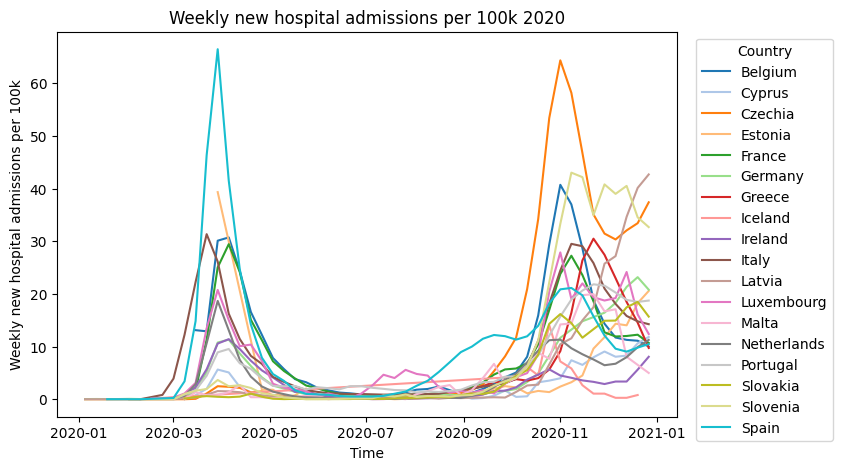

,country,median,std
1,Greece,9.1,9.9
2,Spain,8.9,13.0
3,France,5.4,8.6
4,Belgium,5.4,11.1
5,Luxembourg,4.1,8.0
6,Italy,3.3,9.7
7,Portugal,2.9,7.0
8,Iceland,2.7,4.0
9,Netherlands,1.9,4.8
10,Ireland,1.6,3.0


In [97]:
# Copy admission dateset where Daily hospital occupancy is the indicator
df_weekly = df_admissions[df_admissions['indicator']=='Weekly new hospital admissions per 100k'].copy()

df_2020 = df_weekly[df_weekly['Time'].dt.year == 2020].copy()

# Create figure and colors
fig = mpl.figure(figsize=(8, 5))
ax = fig.add_subplot()
colors = mpl.cm.tab20(np.linspace(0, 1, 19))

# Create a line for each country
for i, country in enumerate(df_2020['country'].unique()):
    country_data_2020 = df_2020[df_2020['country'] == country]
    mpl.plot(country_data_2020['Time'], country_data_2020['value'], label=country, color=colors[i])

# Add info to plot
mpl.xlabel('Time')
mpl.ylabel('Weekly new hospital admissions per 100k')
mpl.legend(title='Country', bbox_to_anchor=(1.02, 1))
mpl.title('Weekly new hospital admissions per 100k 2020')
mpl.show()

# Calculate median and std, create table
# 2020
df_co_2020 = df_2020.groupby('country')['value'].agg(['median','std']).reset_index()
df_co_2020 = df_co_2020.round({'median': 1, 'std': 1})
df_co_2020 = df_co_2020.sort_values(by='median', ascending=False).reset_index(drop=True)
df_co_2020.index += 1

display(df_co_2020)

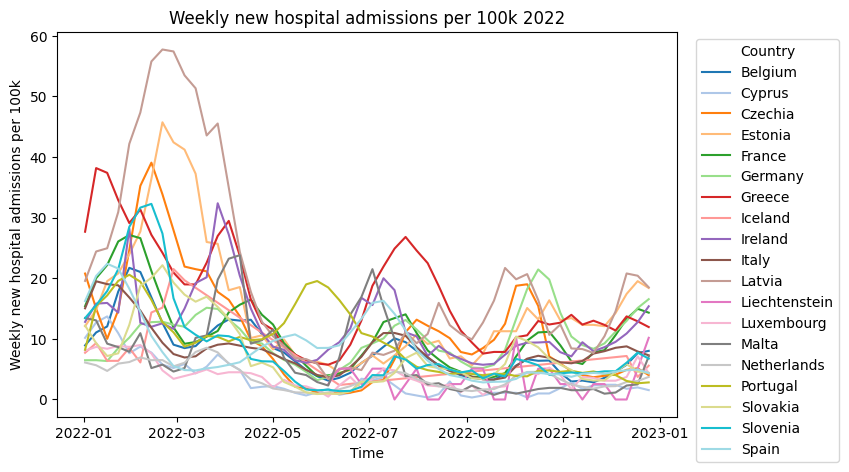

,country,median,std
1,Latvia,13.7,15.7
2,Greece,13.4,8.6
3,Estonia,12.1,10.2
4,Ireland,10.7,5.9
5,France,10.0,6.0
6,Germany,9.6,4.1
7,Czechia,9.3,9.2
8,Portugal,9.0,5.4
9,Italy,7.4,4.0
10,Iceland,7.4,5.8


In [98]:
# Copy admission dateset where Daily hospital occupancy is the indicator
df_weekly = df_admissions[df_admissions['indicator']=='Weekly new hospital admissions per 100k'].copy()
df = df_weekly[df_weekly['Time'].dt.year == 2022].copy()

# Create figure and colors
fig = mpl.figure(figsize=(8, 5))
ax = fig.add_subplot()
colors = mpl.cm.tab20(np.linspace(0, 1, 19))

# Create a line for each country
for i, country in enumerate(df['country'].unique()):
    country_data = df[df['country'] == country]
    mpl.plot(country_data['Time'], country_data['value'], label=country, color=colors[i])

# Add info to plot
mpl.xlabel('Time')
mpl.ylabel('Weekly new hospital admissions per 100k')
mpl.legend(title='Country', bbox_to_anchor=(1.02, 1))
mpl.title('Weekly new hospital admissions per 100k 2022')
mpl.show()

# Calculate median and std, create table
# 2020
df_co = df.groupby('country')['value'].agg(['median','std']).reset_index()
df_co = df_co.round({'median': 1, 'std': 1})
df_co = df_co.sort_values(by='median', ascending=False).reset_index(drop=True)
df_co.index += 1

display(df_co)

***
#### 1.
Did the countries with high skepticism also have more people in the ICU per 100k?